In [ ]:
import torch
import functools
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import math
from tqdm import tqdm, trange
import torch.multiprocessing
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import CelebA
from torchvision.transforms import ToTensor, CenterCrop, Resize, Compose, Normalize

In [ ]:
# Functions to calculate marginal probability and diffusion coefficient
def marginal_prob_std(t, sigma):
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma ** (2 * t) - 1.) / 2. / math.log(sigma))

def diffusion_coeff(t, sigma):
    return torch.tensor(sigma ** t, device=device)

sigma = 25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [ ]:
# Euler-Maruyama sampler for generating samples
def Euler_Maruyama_sampler(score_model, marginal_prob_std, diffusion_coeff, batch_size=64, x_shape=(3, 32, 32), num_steps=500, device='cuda', eps=1e-3, y=None):
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) * marginal_prob_std(t)[:, None, None, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g ** 2)[:, None, None, None] * score_model(x, batch_time_step, cond=y, output_dict=False) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
    return mean_x

In [ ]:
# Load the trained model and embedding
device = 'cuda'
unet_face = UNet_SD(in_channels=3, base_channels=128, time_emb_dim=256, context_dim=256, multipliers=(1, 1, 2), attn_levels=(1, 2), nResAttn_block=1).to(device)
cond_embed = nn.Embedding(40 + 1, 256, padding_idx=40).to(device)

unet_face.load_state_dict(torch.load('fort2/ckpt_unet_SD_face.pth'))
cond_embed.load_state_dict(torch.load('fort2/ckpt_unet_SD_face_cond_embed.pth'))

In [ ]:
# Define transformations and load CelebA dataset
tfm = Compose([Resize(32), CenterCrop(32), ToTensor(), Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
dataset = CelebA("ttoisd", target_type=["attr"], transform=tfm, download=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

In [ ]:
# Get a single image and its attributes
single_image, single_attr = next(iter(dataloader))
single_image = single_image.to(device)
single_attr = single_attr.to(device)

In [ ]:
# Define specific labels for the single image (modify as desired)
desired_labels = single_attr.clone()
#desired_labels[0, 31] = 0  # Set 'smiling' attribute to False
desired_labels[0, 15] = 1# Set 'wearing glasses' attribute to True
#desired_labels[0, 8] = 1 # black hair
#desired_labels[0, 35] = 1 # wearing hat
#desired_labels[0, 39] = 1 # wearing hat

In [ ]:
# Embed the labels
y_emb = cond_embed(desired_labels.to(device))

Files already downloaded and verified


/tmp/ipykernel_1188709/1059873085.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
  0%|                                                                                                                       | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_1188709/1059873085.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma ** t, device=device)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 136.47it/s]


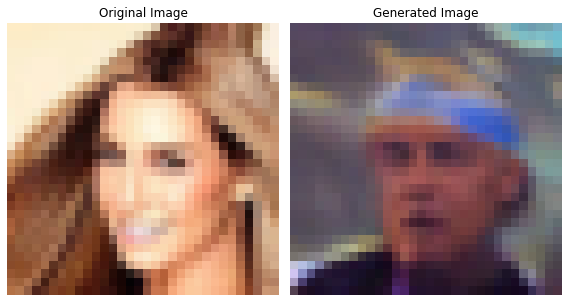

In [32]:
# Function to generate and visualize sample images
def generate_and_visualize_samples(model, y_emb, original_image, device='cuda', num_samples=1, num_steps=250):
    samples = Euler_Maruyama_sampler(model, marginal_prob_std_fn, diffusion_coeff_fn, num_samples, x_shape=(3, 32, 32), num_steps=num_steps, device=device, y=y_emb)

    # Denormalize the samples
    denormalize = Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225])
    samples = denormalize(samples).clamp(0.0, 1.0)
    
    # Visualize the original and generated samples
    plt.figure(figsize=(8, 8))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    original_image_denorm = denormalize(original_image).clamp(0.0, 1.0)
    plt.imshow(original_image_denorm[0].permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.axis('off')
    
    # Generated image
    plt.subplot(1, 2, 2)
    plt.title('Generated Image')
    plt.imshow(samples[0].permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Generate and visualize samples with the desired labels
generate_and_visualize_samples(unet_face, y_emb, single_image)


In [ ]:
'''1.5_o_Clock_Shadow,2.Arched_Eyebrows,3.Attractive,4.Bags_Under_Eyes,5.Bald,6.Bangs,7.Big_Lips,8.Big_Nose,9.Black_Hair,10.Blond_Hair,11.Blurry,12.Brown_Hair
13.Bushy_Eyebrows,14.Chubby,15.Double_Chin,16.Eyeglasses,17.Goatee,18.Gray_Hair,19.Heavy_Makeup,20.High_Cheekbones,21.Male,22.Mouth_Slightly_Open
23.Mustache,24.Narrow_Eyes,25.No_Beard,26.Oval_Face,27.Pale_Skin,28.Pointy_Nose,29.Receding_Hairline,30.Rosy_Cheeks,31.Sideburns,32.Smiling
33.Straight_Hair,34.Wavy_Hair,35.Wearing_Earrings,36.Wearing_Hat,37.Wearing_Lipstick,38.Wearing_Necklace,39.Wearing_Necktie,40.Young

/tmp/ipykernel_1188709/2762284589.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
  0%|                                                                                                                       | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_1188709/2762284589.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma ** t, device=device)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:16<00:00, 14.94it/s]


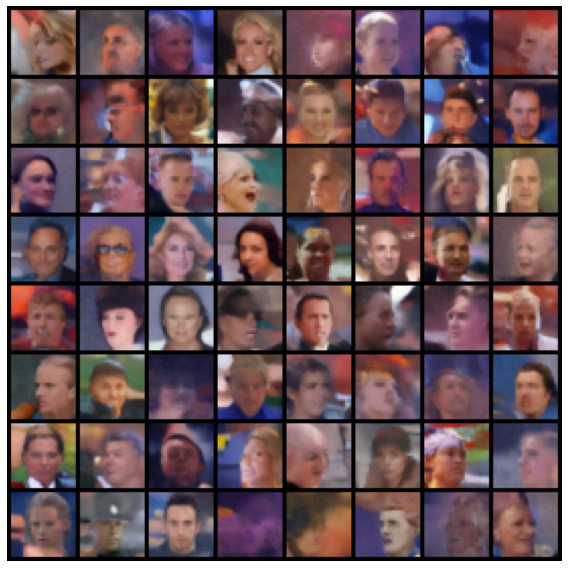

In [24]:
'''import torch
import functools
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import math
from tqdm import tqdm, trange
import torch.multiprocessing
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from StableDiff_UNet_model import UNet_SD, load_pipe_into_our_UNet
from torch.multiprocessing import set_sharing_strategy
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import CelebA
from torchvision.transforms import ToTensor, CenterCrop, Resize, Compose, Normalize

def marginal_prob_std(t, sigma):
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma ** (2 * t) - 1.) / 2. / math.log(sigma))
def diffusion_coeff(t, sigma):
    return torch.tensor(sigma ** t, device=device)


sigma = 25.0  # @param {'type':'number'}-> sigma is a parameter that can be modified or adjusted.
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)
    
def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=64,
                           x_shape=(1, 28, 28),
                           num_steps=500,
                           device='cuda',
                           eps=1e-3,
                           y=None):
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) \
             * marginal_prob_std(t)[:, None, None, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g ** 2)[:, None, None, None] * score_model(x, batch_time_step, cond=y, output_dict=False) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
            # Do not include any noise in the last sampling step.
    return mean_x
    
# Load the trained model and embedding
device = 'cuda'
unet_face = UNet_SD(in_channels=3,
                    base_channels=128,
                    time_emb_dim=256,
                    context_dim=256,
                    multipliers=(1, 1, 2),
                    attn_levels=(1, 2, ),
                    nResAttn_block=1).to(device)

cond_embed = nn.Embedding(40 + 1, 256, padding_idx=40).to(device)

unet_face.load_state_dict(torch.load('fort2/ckpt_unet_SD_face.pth'))
cond_embed.load_state_dict(torch.load('fort2/ckpt_unet_SD_face_cond_embed.pth'))

# Define specific labels (replace with your desired attributes)
# Example: Let's say 0 - '5_o_Clock_Shadow', 1 - 'Arched_Eyebrows', ..., 39 - 'Wearing_Necktie'
# Here we assume 'smiling' is the 31st attribute, and 'wearing glasses' is the 15th attribute.
# modify this according to the specific attributes you have.
desired_labels = torch.zeros(64, 40, dtype=torch.int)  # Batch of 64 samples
desired_labels[:, 31] = 1  # Set 'smiling' attribute to True
desired_labels[:, 15] = 1  # Set 'wearing glasses' attribute to True

# Embed the labels
y_emb = cond_embed(desired_labels.to(device))

# Function to generate and visualize sample images
def generate_and_visualize_samples(model, y_emb, device='cuda', num_samples=64, num_steps=250):
    samples = Euler_Maruyama_sampler(model,
                                     marginal_prob_std_fn,
                                     diffusion_coeff_fn,
                                     num_samples,
                                     x_shape=(3, 32, 32),
                                     num_steps=num_steps,
                                     device=device,
                                     y=y_emb)
    
    # Denormalize the samples
    denormalize = Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225],
                            [1/0.229, 1/0.224, 1/0.225])
    samples = denormalize(samples).clamp(0.0, 1.0)
    sample_grid = make_grid(samples, nrow=int(math.sqrt(num_samples)))
    
    # Visualize the samples
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.tight_layout()
    plt.show()

# Generate and visualize samples with the desired labels
generate_and_visualize_samples(unet_face, y_emb)
